# Stock Price Prediction using LSTM (Long Short-Term Memory)

In order to support the investors on stock market predictions, this notebooks use the architecture of RNN, LSTM, to analyze the NVIDIA evaluation.

* Dataset: https://finance.yahoo.com/quote/NVDA/history/
* Teams:
    * Gabriel dos Santos Lima
    * Augusto César
    * Guilherme Lucas

In [1]:
import pandas as pd 
import numpy as np
import tensorflow
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Importing dataset

In [2]:
data_price = pd.read_csv('./data.csv', delimiter=",")
data_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    250 non-null    object 
 1   Open    250 non-null    float64
 2   High    250 non-null    float64
 3   Low     250 non-null    float64
 4   Close   250 non-null    float64
 5   Volume  250 non-null    object 
dtypes: float64(4), object(2)
memory usage: 11.8+ KB


In [3]:
data_price.head(5)

,Date,Open,High,Low,Close,Volume
0,01/27/2025,124.80,128.40,116.70,118.42,"818,830,938"
1,01/24/2025,148.37,148.97,141.88,142.62,"234,657,594"
2,01/23/2025,145.05,147.23,143.72,147.22,"155,915,500"
3,01/22/2025,144.66,147.79,143.67,147.07,"237,651,391"
4,01/21/2025,139.16,141.83,137.09,140.83,"197,748,984"


## Exploration

In [10]:
def str_to_date(date: str):
    return pd.to_datetime(date)

In [11]:
data_price['Date'] = data_price['Date'].apply(str_to_date)

prices_by_month = data_price.groupby(data_price['Date'].dt.month)['Close'].count()
prices_by_month = pd.DataFrame(zip(prices_by_month.index, prices_by_month.array), columns=['month', 'count'])

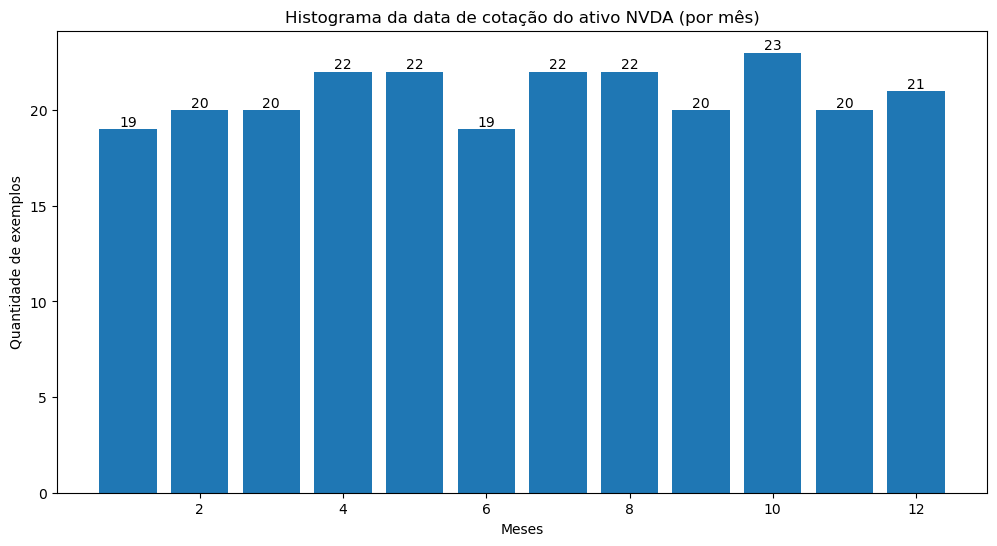

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Histograma da data de cotação do ativo NVDA (por mês)")
plt.xlabel("Meses")
plt.ylabel("Quantidade de exemplos")
bars = plt.bar(prices_by_month['month'], prices_by_month['count'])
plt.bar_label(bars, fontsize=10)
plt.show()

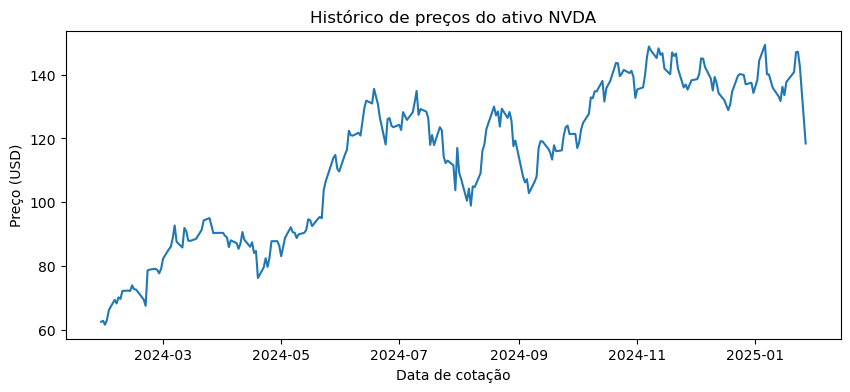

In [21]:
plt.figure(figsize=(10,4))
plt.plot(data_price['Date'], data_price['Close'])
plt.title("Histórico de preços do ativo NVDA")
plt.xlabel('Data de cotação')
plt.ylabel("Preço (USD)")
plt.show()

## Pre-processing

Removing missing values

In [22]:
sanitized_price_data = data_price.dropna()
print(f"{len(sanitized_price_data) - len(data_price)} exemplos foram removidos.")

0 exemplos foram removidos.


Removing unused columns

In [24]:
if 'Open' in sanitized_price_data:
    sanitized_price_data['price'] = ((sanitized_price_data['Open'] + sanitized_price_data['Close']) / 2)
    sanitized_price_data = sanitized_price_data.drop(columns=['Open', 'Close', 'High', 'Low', 'Volume'])

sanitized_price_data.head(4)

,Date,price
0,2025-01-27,121.610
1,2025-01-24,145.495
2,2025-01-23,146.135
3,2025-01-22,145.865


In [25]:
sanitized_price_data = sanitized_price_data.rename(columns={'Date': 'date'})
sanitized_price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    250 non-null    datetime64[ns]
 1   price   250 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


In [26]:
sanitized_price_data = sanitized_price_data.set_index(['date'])
sanitized_price_data.head(4)

,price
date,
2025-01-27,121.610
2025-01-24,145.495
2025-01-23,146.135
2025-01-22,145.865


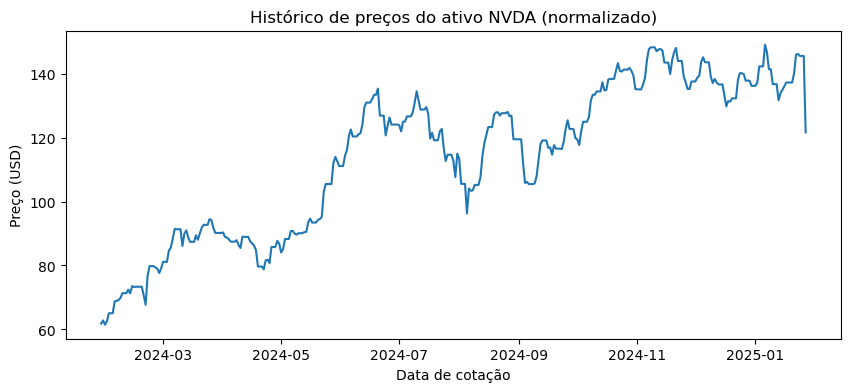

In [31]:
full_range = pd.date_range(sanitized_price_data.index.min(), sanitized_price_data.index.max())
sanitized_price_data = sanitized_price_data.reindex(full_range, method="bfill")

plt.figure(figsize=(10,4))
plt.plot(sanitized_price_data.index, sanitized_price_data['price'])
plt.title("Histórico de preços do ativo NVDA (normalizado)")
plt.xlabel('Data de cotação')
plt.ylabel("Preço (USD)")
plt.show()

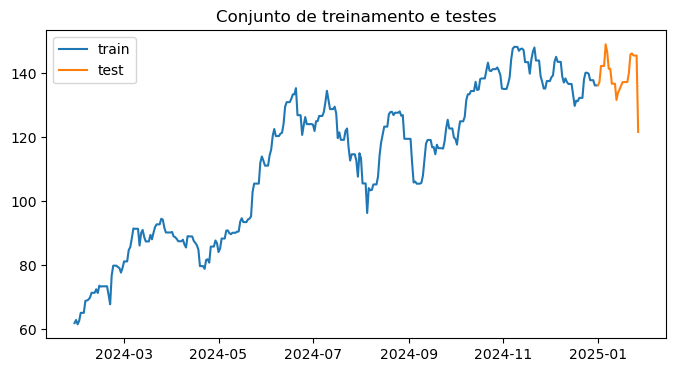

In [32]:
train = sanitized_price_data['2024-01':'2024-12']
test = sanitized_price_data['2025':]

plt.figure(figsize=(8,4))
plt.title("Conjunto de treinamento e testes")
plt.plot(train.index, train['price'], label="train")
plt.plot(test.index, test['price'], label="test")
plt.legend()
plt.show()

## Training

In [ ]:
# TODO

## Analysing the metrics

In [ ]:
# TODO: Uncomment that code after train the model

#y_pred = model.predict(fh=test.index)
#plt.figure(figsize=(8,4))
#plt.title("Previsão do modelo")
#plt.plot(train.index, train['price'], label="train")
#plt.plot(test.index, test['price'], label="test")
#plt.plot(test.index, y_pred['price'], label="prediction")
#plt.legend()
#plt.show()